In [1]:
import os, sys
os.environ['OPENBLAS_NUM_THREADS'] = '1'

PROJECT_ROOT = "/common/users/rp1110/fishcat/Federated-LSRTR"
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST, VesselMNIST3D
import cProfile
from torchvision import transforms
from copy import copy

In [ ]:
# Synthetic Data
shape, ranks, separation_rank = (64, 64), (8, 8), 2
loss_fn = f.mse_loss

sample_size = 2000
val_sample_size = 500
clients = 10

synth_dataset, synth_val_dataset = synthesize_data(shape, ranks, separation_rank,\
                                                   sample_size, val_sample_size)
synth_client_datasets = federate_dataset(synth_dataset, clients)
synth_data = (synth_dataset, synth_client_datasets, synth_val_dataset)

In [ ]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2
loss_fn = logistic_loss

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 10)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)
breast_data = (breast_dataset, breast_client_datasets, breast_val_dataset)

print("fraction positive: ", sum(breast_val_dataset[:, 0][1]) / len(breast_val_dataset[:, 0][1]))

In [ ]:
# Vessel MNIST 3D
vessel_dataset = VesselMNIST3D(split="train", download=True)
vessel_val_dataset = VesselMNIST3D(split="val", download=True)
vessel_client_datasets = federate_dataset(vessel_dataset, 10)
vessel_data = (vessel_dataset, vessel_client_datasets, vessel_val_dataset)
print([len(c) for c in vessel_client_datasets])
print("fraction positive: ", sum(vessel_val_dataset[:, 0][1]) / len(vessel_val_dataset[:, 0][1]))
print(vessel_dataset.labels[0].shape)

In [ ]:
# Tuning
iters = 800
n_workers = 4
n_runs = 8

path_base = "../data/vessel_tuning"
dataset, client_datasets, val_dataset = vessel_data
loss_fn = logistic_loss
aggregator_fn = avg_aggregation

shape, ranks, separation_rank = (28, 28, 28), (3, 3, 3), 2
base_steps = 5
steps_multiplier = [1, 2, 4]
lrs = [0.1, 0.001]
momentums = [0.99, 0.9, 0.8, 0.0]

for sm in steps_multiplier:
    for lr in lrs:
        for momentum in momentums:
            if lr == 0.1 and sm == 1:
                continue
                
            steps = base_steps * sm
            iterations = iters // sm
            
            hypers = {"max_rounds": 1, "max_iter": iterations, "batch_size": None, "lr": lr, "momentum": momentum, "steps": steps, "threshold": 0.0}
            lsr_dot_params = (shape, ranks, separation_rank, torch.float64, torch.device('cuda'))

            print(f"Training lr {lr} steps {steps} momentum {momentum}")
            path = f"{path_base}/lr{int(lr*1000)}_mom{momentum}_steps{steps}"
            args = (lsr_bcd_regression, lsr_dot_params, (dataset, val_dataset, None), hypers, loss_fn, True)

            run_test(path, n_runs, n_workers, *args)


In [ ]:
# Comparison of federated algos
torch.cuda.empty_cache()

#shape, ranks, separation_rank = (64, 64), (8, 8), 2
shape, ranks, separation_rank = (28, 28, 28), (3, 3, 3), 2
lsr_dot_params = (shape, ranks, separation_rank, torch.float64, torch.device('cuda'))

loss_fn = logistic_loss # f.mse_loss
aggregator_fn = avg_aggregation

#site_sizes = [700, 300, 500, 400]
#site_sizes = [0.4, 0.1, 0.3, 0.2, 0.5, 0.7, 1.0]
#client_nums = [2, 4, 6, 8]

site_sizes = [1.0]
client_nums = [4]
iters = 200

n_runs = 1
n_trials = 5
n_workers = 5

path_base = "../data/vessel_tune_200"
    
methods = [BCD_avg_local, lsr_bcd_regression, BCD_federated_stepwise, BCD_federated_all_factors, BCD_federated_full_iteration, BCD_federated_full_iteration]
names = ['local', 'centralized', 'step', 'factors_core', 'one_iter', 'five_iter']

gen_hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 20, "threshold": 0.0}
iter_hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 20, "threshold": 0.0}
iter_5_hypers = {"max_rounds": max(iters // 5, 1), "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 20, "threshold": 0.0}

logistic = True
arg_list = [(gen_hypers, loss_fn, logistic), # local
            (gen_hypers, loss_fn, logistic), # centralized
            (gen_hypers, loss_fn, aggregator_fn, logistic), # one step
            (gen_hypers, loss_fn, aggregator_fn, logistic), # factors core
            (iter_hypers, loss_fn, aggregator_fn, logistic), # one iter
            (iter_5_hypers, loss_fn, aggregator_fn, logistic)] # five iter

trial_args = []
for samples in site_sizes:
    for clients in client_nums:
        sized_names = [f"{name}_{int(samples*100)}_{clients}" for name in names]
        trial_args.append((path_base, n_runs, n_trials, n_workers, samples, clients, lsr_dot_params, sized_names, methods, arg_list))
        
print ("---STARTING---")

#with mp.get_context('spawn').Pool(processes=1) as pool:
#    pool.starmap(run_vessel_combined, trial_args)
    
run_vessel_combined(*trial_args[0])
#print(f"size: {size}, clients: {clients}")
#run_combined_test(path_base, n_runs, n_trials, n_workers, data_fn, lsr_dot_params, sized_names, methods, arg_list)

In [ ]:
os.listdir('../data/vessel_tuning')

In [179]:
#Load data from runs (loss vs. iterations)
path_base = "../data/synth_final"
size = 500
clients = 6

names = [f"centralized", f"step", f"factors_core", f"one_iter", f"five_iter", f"local"]
#names = os.listdir('../data/vessel_tuning')
print(names)
#names = [f"lr{int(lr*1000)}_mom{momentum}" for momentum in [0.0, 0.9, 0.99] for lr in [0.1, 0.003, 0.001]]

train_losses, train_std = [], []
val_losses, val_std = [], []

train_accs, train_acc_std = [], []
val_accs, val_acc_std = [], []

for name in names:
    path = f"{path_base}/{name}_{size}_{clients}"
    train_losses.append(torch.mean(torch.load(f"{path}/train_loss"), axis=0))
    train_std.append(torch.std(torch.load(f"{path}/train_loss"), axis=0))

    val_losses.append(torch.mean(torch.load(f"{path}/val_loss"), axis=0))
    val_std.append(torch.std(torch.load(f"{path}/val_loss"), axis=0))

    """train_accs.append(torch.mean(torch.load(f"{path}/train_auc"), axis=0))
    train_acc_std.append(torch.std(torch.load(f"{path}/train_auc"), axis=0))

    val_accs.append(torch.mean(torch.load(f"{path}/val_auc"), axis=0))
    val_acc_std.append(torch.std(torch.load(f"{path}/val_auc"), axis=0))"""

print("Loaded run data")
print([vl.shape for vl in val_losses])

['centralized', 'step', 'factors_core', 'one_iter', 'five_iter', 'local']
Loaded run data
[torch.Size([200]), torch.Size([200]), torch.Size([200]), torch.Size([200]), torch.Size([40]), torch.Size([200])]


In [ ]:
#Load data from runs (min loss vs. size comparison)
path_base = "../data/synth_final"

site_sizes = [100, 200, 300, 400, 500, 700, 1000]
clients=8

train_losses, train_std = [], []
val_losses, val_std = [], []

names = [f"centralized", f"step", f"factors_core", f"one_iter", f"five_iter", f"local"]

for name in names:
    size_best_train, size_best_train_std = [], []
    size_best_val, size_best_val_std = [], []

    for size in site_sizes:
        full_name = f"{name}_{size}_{clients}"    
        path = f"{path_base}/{full_name}"
        
        size_best_train.append(torch.mean(torch.load(f"{path}/train_loss").min(dim=1).values))
        size_best_train_std.append(torch.std(torch.load(f"{path}/train_loss").min(dim=1).values))
        
        size_best_val.append(torch.mean(torch.load(f"{path}/val_loss").min(dim=1).values))
        size_best_val_std.append(torch.std(torch.load(f"{path}/val_loss").min(dim=1).values))

    train_losses.append(torch.stack(size_best_train))
    train_std.append(torch.stack(size_best_train_std))
    val_losses.append(torch.stack(size_best_val))
    val_std.append(torch.stack(size_best_val_std))
    
print("Loaded run data")
print([vl.shape for vl in val_losses])

In [161]:
#Load data from runs (samples vs. clients heatmap)
path_base = "../data/synth_final"

sizes = [100, 200, 300, 400, 500, 700, 1000]
clients_ls = [2, 4, 6, 8]

train_losses, train_std = [], []
val_losses, val_std = [], []

names = [f"centralized", f"factors_core", f"one_iter", f"five_iter"]

for name in names:
    indices = []
    size_best_train, size_best_train_std = [], []
    size_best_val, size_best_val_std = [], []

    for size in sizes:
        clients_best_train, clients_best_train_std = [], []
        clients_best_val, clients_best_val_std = [], []
        clients_indices = []
        
        for clients in clients_ls:
            clients_indices.append(torch.tensor(clients*size))
            
            full_name = f"{name}_{size}_{clients}"    
            path = f"{path_base}/{full_name}"

            clients_best_train.append(torch.mean(torch.load(f"{path}/train_loss").min(dim=1).values))
            clients_best_train_std.append(torch.std(torch.load(f"{path}/train_loss").min(dim=1).values))

            clients_best_val.append(torch.mean(torch.load(f"{path}/val_loss").min(dim=1).values))
            clients_best_val_std.append(torch.std(torch.load(f"{path}/val_loss").min(dim=1).values))
            
        size_best_train.append(torch.stack(clients_best_train))
        size_best_train_std.append(torch.stack(clients_best_train_std))
        
        size_best_val.append(torch.stack(clients_best_val))
        size_best_val_std.append(torch.stack(clients_best_val_std))
        
        indices.append(torch.stack(clients_indices))

    train_losses.append(torch.stack(size_best_train))
    train_std.append(torch.stack(size_best_train_std))
    val_losses.append(torch.stack(size_best_val))
    val_std.append(torch.stack(size_best_val_std))
    
print("Loaded run data")
print([vl.shape for vl in val_losses])

Loaded run data
[torch.Size([7, 4]), torch.Size([7, 4]), torch.Size([7, 4]), torch.Size([7, 4])]


6


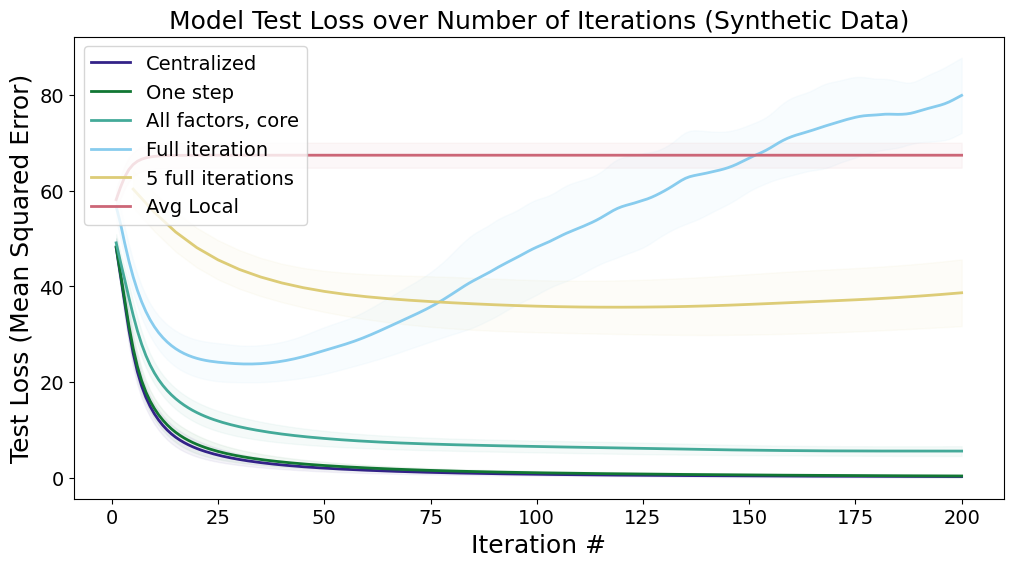

In [181]:
# loss vs iterations graph

colors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#5D070A"]
labels = ["Centralized", "One step", "All factors, core", "Full iteration", "5 full iterations", "Avg Local"]
#labels = names

metrics = val_losses
stds = val_std

print(len(names))

xscales = [200 // len(x) for x in metrics]

plt.figure(figsize=(12, 6))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot((np.arange(len(metric)) + 1)*xscale, metric, label=label, linewidth=2, color=color)
    plt.fill_between((np.arange(len(metric)) + 1)*xscale, metric-std, metric+std, alpha=0.05, color=color)

legend = plt.legend(loc='upper left', fontsize=14)

# Set x and y tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Iteration #", fontsize=18)
plt.ylabel("Test Loss (Mean Squared Error)", fontsize=18)
plt.title("Model Test Loss over Number of Iterations (Synthetic Data)", fontsize=18)
plt.show()

In [ ]:
# min loss vs num samples graph

colors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#5D070A"]
labels = ["Centralized", "One step", "All factors, core", "Full iteration", "5 full iterations", "Avg Local"]
#labels = names

xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]

metrics = val_losses
stds = val_std

plt.figure(figsize=(10, 5))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot(site_sizes, metric, label=label, color=color, marker='o')
    plt.fill_between(site_sizes, metric-std, metric+std, color=color, alpha=0.2)

plt.legend()
plt.xlabel("Amt of Data at Each Site", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Minimum Validation Loss over Site Sample Size\n (Synthetic Data)", fontsize=16)
plt.show()

tensor([[ 7.5675,  0.3009,  0.2650,  0.2605],
        [40.5196,  0.3241,  0.2371,  0.2954],
        [50.9073,  3.9304,  0.3512,  0.2046],
        [58.3295, 28.3500,  0.8507,  0.2313],
        [58.2764, 47.6899, 18.5465,  0.6733],
        [63.6609, 56.0221, 44.1816, 29.6098],
        [66.4985, 63.4066, 62.5203, 59.3065]])
tensor([[2000, 4000, 6000, 8000],
        [1400, 2800, 4200, 5600],
        [1000, 2000, 3000, 4000],
        [ 800, 1600, 2400, 3200],
        [ 600, 1200, 1800, 2400],
        [ 400,  800, 1200, 1600],
        [ 200,  400,  600,  800]])


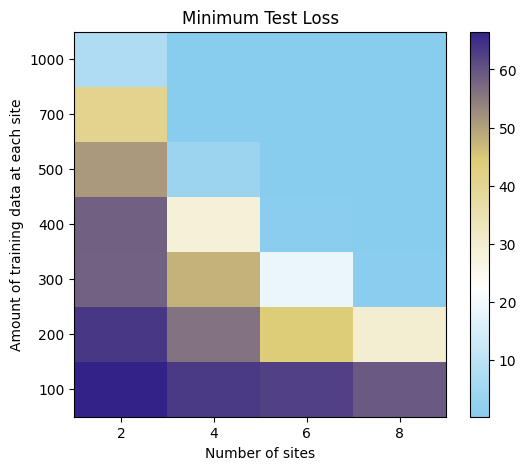

In [67]:
#heatmap

metrics = val_losses[0] #/ val_losses[0]
metrics = torch.flip(metrics, dims=(0,))
#metrics = torch.min(metrics, torch.full_like(metrics, fill_value=2))

print(metrics)
print(torch.flip(torch.stack(indices), dims=(0,)))

colors = ["#88CCEE", "#FFFFFF", "#DDCC77", "#332288"]  # Blue, White, Red
#colors = ["#88CCEE", "#DDCC77", "#332288"]
class CustomThreeSlopeNorm(matplotlib.colors.Normalize):
    def __init__(self, min_value, max_value, mid_value):
        self.min_value = min_value
        self.max_value = max_value
        self.mid_value = mid_value
        super().__init__(vmin=min_value, vmax=max_value)

    def __call__(self, value, clip=None):
        return (value < 1) * (value - self.min_value) / (1 - self.min_value) / 3 +\
               ((value > 1) & (value < self.mid_value)) * ((value - 1) / (self.mid_value - 1) / 3 + 1/3)+\
               (value > self.mid_value) * ((value - self.mid_value) / (self.max_value - self.mid_value) / 3 + 2/3)

mid_val = 2

# Create an instance of the custom normalization class
#custom_norm = CustomThreeSlopeNorm(metrics.min().numpy(), metrics.max().numpy(), mid_val)

cmap_name = 'custom_heatmap'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=10000)

plt.figure(figsize=(6, 5))
heatmap = plt.imshow(metrics, cmap=cmap, aspect='auto') #norm=custom_norm
cbar = plt.colorbar(heatmap)
#cbar.ax.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(numticks=4))  # Specify the number of ticks
#cbar.ax.set_yticklabels([f"{metrics.min().numpy():.2f}", 1, mid_val, f"{metrics.max().numpy():.2f}"])  # Set the tick labels

x_ticks = [0, 1, 2, 3]
y_ticks = [0, 1, 2, 3, 4, 5, 6]
x_labels = [2, 4, 6, 8]
y_labels = [100, 200, 300, 400, 500, 700, 1000][::-1]

plt.xticks(x_ticks, x_labels)
plt.yticks(y_ticks, y_labels)
plt.xlabel('Number of sites')
plt.ylabel('Amount of training data at each site')

plt.title('Minimum Test Loss')
plt.show()

/tmp/ipykernel_2632767/1429493357.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(cbar_labels, fontsize=14)
/tmp/ipykernel_2632767/1429493357.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.92, 0.95])  # Adjust the rect parameter for tight_layout


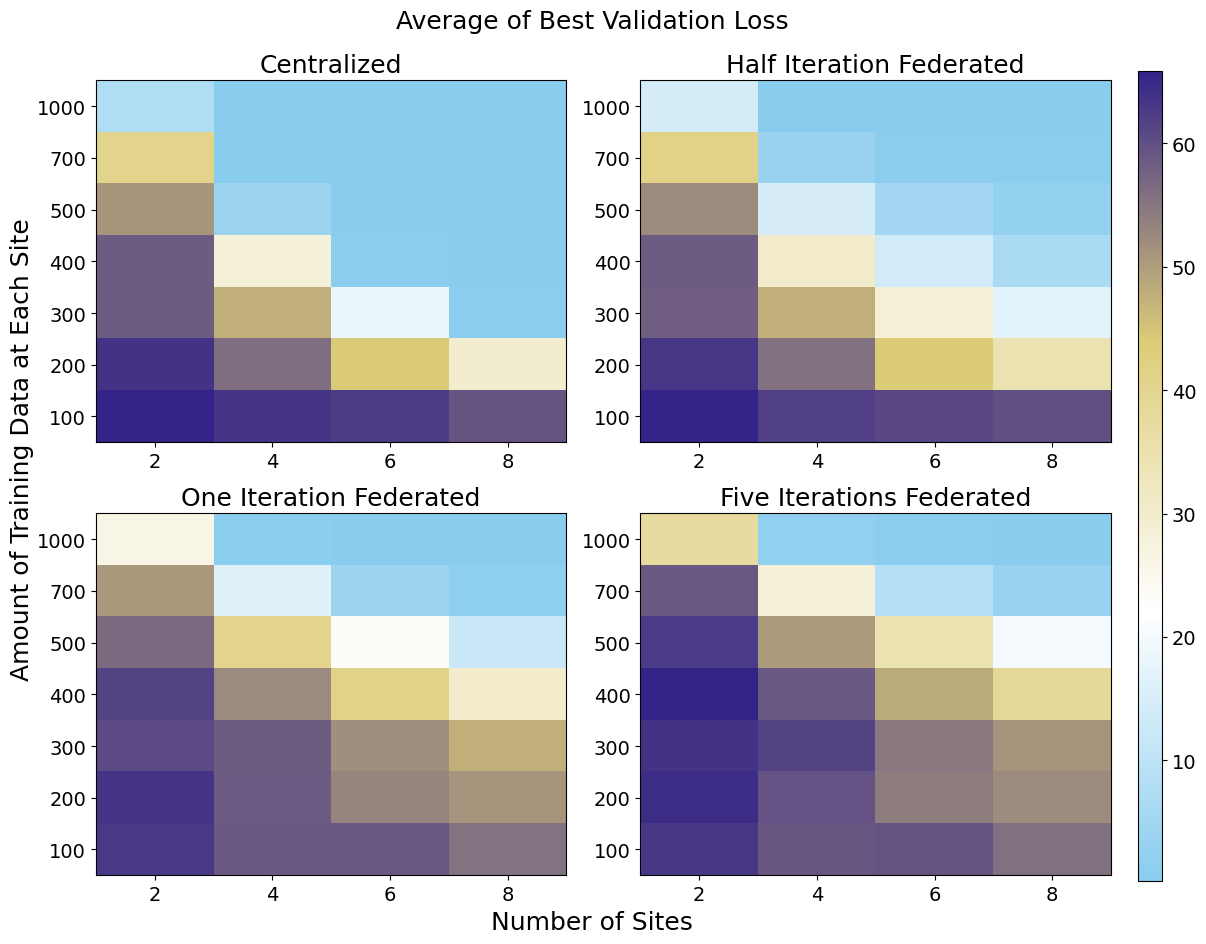

In [171]:
# Colors for the custom colormap
colors = ["#88CCEE", "#FFFFFF", "#DDCC77", "#332288"]  # Blue, White, Red

# Custom normalization function
class CustomThreeSlopeNorm(matplotlib.colors.Normalize):
    def __init__(self, min_value, max_value, mid_value):
        self.min_value = min_value
        self.max_value = max_value
        self.mid_value = mid_value
        super().__init__(vmin=min_value, vmax=max_value)

    def __call__(self, value, clip=None):
        return (value < 1) * (value - self.min_value) / (1 - self.min_value) / 3 +\
               ((value > 1) & (value < self.mid_value)) * ((value - 1) / (self.mid_value - 1) / 3 + 1/3)+\
               (value > self.mid_value) * ((value - self.mid_value) / (self.max_value - self.mid_value) / 3 + 2/3)

# Create a figure and adjust the title
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Average of Best Validation Loss', fontsize=18, y=0.94, x=0.475)

all_min = min([vl[i].min() for vl in val_losses])
all_max = max([vl[i].max() for vl in val_losses])
all_norm = matplotlib.colors.Normalize(all_min, all_max)
#custom_norm = CustomThreeSlopeNorm(metrics.min(), metrics.max(), 5)

# Create the custom colormap
cmap_name = f'custom_heatmap_{i}'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, colors, N=10000)
    
# Iterate through val_losses indices and subplot labels
for i, label in enumerate(["Centralized", "Half Iteration Federated", "One Iteration Federated", "Five Iterations Federated"]):
    # Calculate the metrics for the current index
    metrics = val_losses[i]
    metrics = torch.flip(metrics, dims=(0,)).numpy()

    # Plot the heatmap
    im = axs[i // 2, i % 2].imshow(metrics, cmap=cmap, norm=all_norm, aspect='auto')
    axs[i // 2, i % 2].set_title(label, fontsize=18)  # Set subplot title

    # Set x and y tick marks
    axs[i // 2, i % 2].set_xticks([0, 1, 2, 3])
    axs[i // 2, i % 2].set_yticks([0, 1, 2, 3, 4, 5, 6])

    axs[i // 2, i % 2].set_xticklabels([2, 4, 6, 8], fontsize=14)
    axs[i // 2, i % 2].set_yticklabels([100, 200, 300, 400, 500, 700, 1000][::-1], fontsize=14)

# Create a single color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.068, 0.02, 0.81])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.ax.yaxis.set_major_locator(plt.LinearLocator(numticks=4))

# Adjust color bar labels
cbar_labels = [all_min, 10, 20, 30, 40, 50, 60, all_max]
cbar.ax.set_yticklabels(cbar_labels, fontsize=14)

# Label the overall x and y axes
fig.text(0.475, 0.02, 'Number of Sites', ha='center', fontsize=18)
fig.text(-0.01, 0.5, 'Amount of Training Data at Each Site', va='center', rotation='vertical', fontsize=18)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 0.92, 0.95])  # Adjust the rect parameter for tight_layout
plt.show()


In [ ]:
print("Testing...")

hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = logistic_loss
lsr_dot_params = (shape, (3, 3, 3), 2, torch.float64, torch.device('cuda'))

init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
lsr_bcd_regression(init_lsr_dot, loss_fn, vessel_dataset, vessel_val_dataset,\
                       hypers, True, True)

print("Finished without errors")

In [ ]:
# Performance testing
print("Performance Testing...")
hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.005, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("BCD_federated_stepwise(init_lsr_dot, synth_client_datasets, synth_val_dataset,\
              hypers, loss_fn, aggregator_fn, False)", sort='tottime')

In [ ]:
# Perf testing
shape, ranks, separation_rank = (64, 64), (8, 8), 2
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))

loss_fn = f.mse_loss
aggregator_fn = avg_aggregation

iters = 10

n_runs = 1
n_trials = 8
n_workers = 8

path_base = "../data/synth_size_test"

def data_fn_by_size(sample_size, val_sample_size=500, clients=10):
    synth_tensor = get_synth_tensor(shape, ranks, separation_rank)
    synth_dataset, synth_val_dataset = synthesize_data(synth_tensor, sample_size*clients, val_sample_size)
    synth_client_datasets = federate_dataset(synth_dataset, clients)
    return (synth_dataset, synth_val_dataset, synth_client_datasets)
    
def data_fn():
    return data_fn_by_size(sample_size=100)

methods = [BCD_avg_local, lsr_bcd_regression, BCD_federated_stepwise, BCD_federated_all_factors, BCD_federated_full_iteration, BCD_federated_full_iteration]
names = ['local', 'centralized', 'step', 'factors_core', 'one_iter', 'five_iter']

gen_hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_hypers = {"max_rounds": iters, "max_iter": 1, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
iter_5_hypers = {"max_rounds": iters // 5, "max_iter": 5, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

arg_list = [(gen_hypers, loss_fn, False), # local
            (gen_hypers, loss_fn, False), # centralized
            (gen_hypers, loss_fn, aggregator_fn, False), # one step
            (gen_hypers, loss_fn, aggregator_fn, False), # factors core
            (iter_hypers, loss_fn, aggregator_fn, False), # one iter
            (iter_5_hypers, loss_fn, aggregator_fn, False)] # five iter

cProfile.run("run_combined_test(path_base, n_runs, n_trials, n_workers, data_fn, lsr_dot_params, names, methods, arg_list)", sort='tottime')